# Policy embeddings / k-means for POMDP graph navigation
Codebase for 'Efficient search of active inference policy spaces using k-means'

(c) 2020-2022 Alex Kiefer & Mahault Albarracin / VERSES Labs

### IMPORTS

In [302]:
import random
import os
import sys
import glob
import pathlib
import copy
import time
import uuid

import numpy as np
import pandas as pd
import itertools
import networkx as nx
from networkx.generators.random_graphs import erdos_renyi_graph

import matplotlib.pyplot as plt
from random import sample, randint
from tqdm import tqdm
from multiprocessing import Pool

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


path = pathlib.Path(os.getcwd())
module_path = str(path.parent) + '/'
sys.path.append(module_path)

try:
    import pymdp.core.control as control
    from pymdp.core import utils
except:
    import pymdp.control as control
    from pymdp import utils
    

from scipy.special import softmax, kl_div
from scipy.stats import entropy

import sklearn
from sklearn.decomposition import PCA

## 1. BUILD GRAPH

In [303]:
def generate_graph(n=5, p=None, weight_options=None, idleness_penalty=100):
    
    if p is None:
        p = 2/n # Use instead of previous default of 0.5 to avoid exponential complexity increase with graph size

    G = erdos_renyi_graph(n, p, directed=True)        
    while not nx.is_weakly_connected(G):
        G = erdos_renyi_graph(n, p, directed=True)

    weight_options = weight_options or [5,5,10,20]
    node_color="gray"
    pos = [0,1,2,3,4,5,6]

    for i in G.edges():
        G[i[0]][i[1]]['weight'] = random.choice(weight_options)
        edge_weight = G.get_edge_data(i[0], i[1])
        G.add_edge(i[1],i[0], weight=edge_weight["weight"]) 

    for e in G.nodes():
        G.add_edge(e,e,weight=idleness_penalty)
        G.nodes[e]["pos"]=[e, random.choice(pos) ]

    nx.set_node_attributes(G, node_color, "node_color")

    G.removed_edges = [] # Special property for keeping track of removed tracks
    G.idleness_penalty = idleness_penalty
    #G.shortest_paths = {k: v for (k, v) in list(nx.all_pairs_dijkstra_path(G))} 
    G.distances = {k: v for (k, v) in list(nx.all_pairs_dijkstra_path_length(G))}
    
    
    return G


### Get attributes and plot graph

In [304]:
def plot_graph(graph, path=None, labels_on=True):
    if path:
        start = path[0]
        end = path[-1]        
        path_edges = []
        
        for idx, node in enumerate(path[1:]):
            if idx < len(path) - 1:
                path_edges.append((path[idx], path[idx+1]))
            nx.set_node_attributes(graph, {node: "yellow"}, name="node_color")

        nx.set_node_attributes(graph, {start: "green"}, name="node_color")
        nx.set_node_attributes(graph, {end: "#8757b0"}, name="node_color")
    
    all_edges = list(graph.edges())
    node_pos=nx.get_node_attributes(graph,'pos')
    graph_weights = [graph[u][v]['weight'] for u,v in all_edges]
    node_colors= []
    for node in list(graph.nodes(data=True)):
        node_colors.append(node[1]["node_color"])

    nx.draw(graph, with_labels=True, node_size = 300, pos=node_pos, node_color=node_colors, width=1)
    nx.draw_networkx_edges(graph, node_pos)
    if path:
        nx.draw_networkx_edges(graph, pos=node_pos, edgelist=path_edges, width=4, edge_color='r')

    edge_labels = {e: w for e, w in zip(all_edges, graph_weights)}
    if labels_on:
        nx.draw_networkx_edge_labels(graph, node_pos, edge_labels=edge_labels)

    plt.show()


## 2. BUILD GENERATIVE MODEL

### Set up states, observations, and actions

In [315]:
def observations_from_graph(graph):
    return {
        "pair_plus_edge_weight": 
        list([[edge, graph.get_edge_data(edge[0], edge[1])["weight"]] for edge in list(graph.edges)])
    }
    
def get_weights(observations):
    return np.array([obs[1] for obs in observations['pair_plus_edge_weight']])
    
def state_space_from_graph(graph):
    states = {"node_pair": list(graph.edges)}
    observations = observations_from_graph(graph)
    actions = {"change_location": 
        [edge for edge in list(itertools.product(list(graph.edges),repeat=2)) 
        if edge[0][1] == edge[1][0]]
    }
    
    # Handy variables for dimensions of state space
    num_state_factors = len(states)
    num_states = [len(states[factor]) for factor in states]
    num_modalities = len(observations)
    num_observations = [len(observations[modality]) for modality in observations]
    num_actions = len(actions['change_location'])
    
    # Summarize edge weights in a variable
    weights = np.array([obs[1] for obs in observations['pair_plus_edge_weight']])
    
    return states, observations, actions, num_state_factors, num_states, num_modalities, num_observations, num_actions, weights


### Set up policies

In [307]:
def find_paths_recursive(graph,u,n):
    if n==0:
        return [[u]]
    paths = [[u]+path for neighbor in graph.neighbors(u) for path in find_paths_recursive(graph,neighbor,n-1)]
    return paths


def find_paths_all_nodes(graph, policy_len, disable_tqdm=True):
    paths = []
    for n in tqdm(graph.nodes(), disable=disable_tqdm):
        paths += find_paths_recursive(graph, n, policy_len)
    return paths


def convert_to_edges(paths, disable_tqdm=True):
    path_edges = []
    for path in tqdm(paths, disable=disable_tqdm):
        one_path_edges = []
        for idx,node in enumerate(path[1:]):
            one_path_edges.append((path[idx],path[idx+1]))
        path_edges.append(one_path_edges)
    
    return path_edges


def convert_to_policies(edge_sets, actions, policy_len, num_controllable_factors, disable_tqdm=True):
    path_policies = []
    for edge_set in tqdm(edge_sets, disable=disable_tqdm):
        edge_actions = []
        for idx, edge_tuple in enumerate(edge_set[1:]):
            edge_actions.append(actions['change_location'].index((edge_set[idx], edge_set[idx+1])))
        path_policies.append(np.array(edge_actions).reshape(policy_len, num_controllable_factors))
    
    return path_policies


def get_policies_from_graph(graph, actions, num_controllable_factors, policy_len=None):
    """
    Get all policies on graph that are 'well-formed', i.e. only actions that begin 
    on the node that the previous action ended at are used
    """
    if not policy_len:
        policy_len = len(list(graph.nodes()))
    print("Getting paths recursively...")
    paths = find_paths_all_nodes(graph, policy_len+1)
    print("Getting edges...")
    path_edges = convert_to_edges(paths)
    print("Getting policies...")
    return np.array(convert_to_policies(path_edges, actions, policy_len, num_controllable_factors))


### Set up matrices
#### A Matrix
Structure: [observation_modality][observation_level, state_factor_1, ..., state_factor_n]

In [308]:
def A_setup(num_states, num_state_factors):
    # For now assuming just one observation modality and an identity mapping
    return np.array([
        np.eye(num_states[factor]) for factor in range(num_state_factors)
    ], dtype='object')


#### B Matrix
Structure: [state_factor][current_state, previous_state, action]

In [309]:
def B_setup(states, actions, graph, num_states, num_state_factors, num_actions):
    B = np.array([
        np.zeros((num_states[factor], num_states[factor], num_actions))
        for factor in range(num_state_factors)
    ], dtype='object')

    # Fill out values for valid moves
    for factor_idx, factor in enumerate(states):
        for prev_idx in range(num_states[factor_idx]):
            for current_idx in range(num_states[factor_idx]):
                for action_idx in range(num_actions):
                    if (
                        states['node_pair'][prev_idx], 
                        states['node_pair'][current_idx]
                    ) == actions['change_location'][action_idx]:
                        if actions['change_location'][action_idx][0] in list(graph.edges):
                            B[factor_idx,current_idx,prev_idx,action_idx] = 1.
                        else:
                            resulting_state_idx = states['node_pair'].index(
                                (states['node_pair'][prev_idx][1], 
                                 states['node_pair'][prev_idx][1])
                            )
                            B[factor_idx,resulting_state_idx,prev_idx,action_idx] = 1.
                    else:
                        if states['node_pair'][prev_idx] != actions['change_location'][action_idx][0]:
                            resulting_state_idx = states['node_pair'].index(
                                (states['node_pair'][prev_idx][1], 
                                 states['node_pair'][prev_idx][1])
                            )
                            B[factor_idx,resulting_state_idx,prev_idx,action_idx] = 1.
    return B


#### C Matrix

In [310]:
def C_setup(graph, states, num_states, desired_state_idx=None, graph_to_augment=None):

    # For now, assume just one observation modality
    C = np.array([
        np.zeros(num_states[idx]) for idx, factor in enumerate(states)
    ], dtype = 'float32')

    if desired_state_idx is not None:
        destination = desired_state_idx
    else:
        # Choose a random destination node
        destination = np.random.randint(len(list(graph.nodes)))

    # Distribute positive preferences over paths that terminate at this destination
    desired_indices = np.where(
        np.array([states['node_pair'][state][1] for state in range(num_states[0])]) 
        == destination
    )[0]
    
    print("Desired indices", desired_indices)
    if len(desired_indices) > 0:
        C[0][desired_indices] = 1./len(desired_indices)
    else:
        print("Destination unreachable. C matrix is flat")
        C[0] += 1./C[0].shape[0]
    
    if graph_to_augment:
        for idx in range(graph_to_augment.number_of_nodes()):
            if idx != desired_state_idx:
                G[idx][idx]['weight'] = 0
    
    return C, destination


#### D Matrix / initial conditions

In [311]:
def D_setup(graph, states, num_states, num_state_factors, initial_state=None):
        
    if initial_state is None:
        edges = list(graph.edges())
        initial_state_idx = np.random.choice(len(edges))
        initial_state = edges[initial_state_idx]
        print(initial_state)
    
    initial_beliefs = np.array([
        np.zeros(num_states[factor_idx])
        for factor_idx in range(num_state_factors)
    ])
    initial_beliefs[0][states['node_pair'].index(initial_state)] = 1.
    
    return initial_beliefs


## 3. K-means on policy embeddings

### Policy embedding: edit distance matrix

In [312]:
def expand(policy, action_data):
    return [action_data[x[0]] for x in policy]


def extract_edges(policy, action_data, return_set=True):
    result = []  
    for action in expand(policy, action_data):
        result += [action[0], action[1]]
    if return_set:
        return set(result)

    return result


def extract_nodes(edges):
    result = []
    for edge in edges:
        result += [edge[0], edge[1]]
    return set(result)


def edit_distance(graph_A, graph_B, action_data):
    
    A_edges, B_edges = extract_edges(graph_A, action_data), extract_edges(graph_B, action_data)
    diff_edges = distinct_elements(A_edges, B_edges)
    
    A_nodes, B_nodes = extract_nodes(A_edges), extract_nodes(B_edges)
    diff_nodes = distinct_elements(A_nodes, B_nodes)
    
    return len(diff_edges) + len(diff_nodes)

    
def distinct_elements(set_A, set_B):
    return set_A.union(set_B) - set_A.intersection(set_B)

            
def edit_distance_matrix(policies, action_data, disable_tqdm=True):
    num_policies = len(policies)
    matrix = np.zeros((num_policies, num_policies), dtype='uint8')
    
    for i in tqdm(range(num_policies), disable=disable_tqdm):
        for j in range(num_policies):
            matrix[i,j] = edit_distance(policies[i], policies[j], action_data)
    return matrix
            

def starts_with(policy, location, action_data):
    return expand(policy, action_data)[0][0] == location


def print_policies(policy_list, action_data):
    for x in policy_list:
        print(expand(x, action_data))

### Policy embedding: Bag-of-policies

In [313]:
def bag_of_edges(graph, policies, action_data, disable_tqdm=True):
    bag = []
    for policy in tqdm(policies, disable=disable_tqdm):
        bag.append(np.array([list(extract_edges(policy, action_data)).count(edge) for edge in graph.edges()]))
    
    return bag

def bag_of_edges_augmented(graph, policies, action_data, disable_tqdm=True):
    bag = []
    for policy in tqdm(policies, disable=disable_tqdm):
        edges = list(graph.edges())
        policy_edges = extract_edges(policy, action_data, return_set=False)
        first_edge = edges.index(policy_edges[0])
        last_edge = edges.index(policy_edges[1])
        bag.append(np.array([list(extract_edges(policy, action_data)).count(edge) for edge in edges] + [first_edge, last_edge]))
    
    return bag

## K-means clustering on embedding space

In [314]:
def get_kmeans(embedding, num_clusters=12, init_strategy=None):    
    return KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(embedding))


def get_local_policies(policies, current_location):
    return [x for x in policies if starts_with(x, current_location)]


def get_local_embedding(embedding, current_location, policies):
    embedding_copy = copy.deepcopy(embedding)
    embedding_copy = [x for idx, x in enumerate(embedding_copy) if starts_with(policies[idx], current_location)]

    return embedding_copy


def get_kmeans_local(embedding, current_location, policies, num_clusters=12, disable_tqdm=True):

        
    embedding_copy = copy.deepcopy(embedding)
    if current_location:
        embedding_copy = [x for idx, x in tqdm(enumerate(embedding_copy), disable=disable_tqdm) if starts_with(policies[idx], current_location)]

    return embedding_copy, KMeans(n_clusters=num_clusters, random_state=0).fit(np.array(embedding_copy))


## 4. AGENT AND SIMULATION
Core active inference policy selection functions adapted from pymdp tutorial notebook

## Agent class


In [293]:
def select_random_points(clusters, number_of_points):
    selected_points=[]
    for cluster in clusters:
        selected_points.append(random.sample(cluster, min(len(cluster), number_of_points)))
        
    return selected_points


EMBEDDINGS = ["EDM", "BOE", "aBOE"]


class GraphAgent():
    def __init__(
        self, 
        graph, 
        embedding_style="None", 
        embeddings=EMBEDDINGS, 
        local_policies=True,
        k=12,
        num_samples=1,
        weight_coefficient=5
    ):
        self.graph = graph
        self.local_policies = local_policies
        self.weight_coefficient = weight_coefficient
        self.idleness_penalty = graph.idleness_penalty
        self.k = k
        self.num_samples = num_samples
        self.kmeans_time = None
        self.use_kmeans = embedding_style != "None"

        # States, observations, actions
        ( self.states,
        self.observations, 
        self.actions, 
        self.num_state_factors, 
        self.num_states, 
        self.num_modalities, 
        self.num_observations, 
        self.num_actions, 
        self.weights ) = state_space_from_graph(graph)
 
        # Generative model
        self.A = A_setup(self.num_states, self.num_state_factors)
        self.B = B_setup(self.states, self.actions, graph, self.num_states, self.num_state_factors, self.num_actions)
        self.C, self.desired_node = C_setup(graph, self.states, self.num_states)
        self.D = D_setup(graph, self.states, self.num_states, self.num_state_factors)
        
        # Policies
        self.policy_len = len(list(graph.nodes()))
        print("Deriving policies from graph...")
        self.all_policies = get_policies_from_graph(graph, self.actions, self.num_state_factors)
        self.policies = copy.deepcopy(self.all_policies)
        
        self.initialize_beliefs_and_state()
        self.initialize_logs()
        self.reset_weights()

        # Embeddings
        self.embedding_style = embedding_style
        self.embeddings = {}
        self.construction_times = {}
        
        if "EDM" in embeddings:
            print("Building edit distance matrix representation...")
            start = time.time()
            self.embeddings["EDM"] = edit_distance_matrix(self.all_policies, self.actions["change_location"])
            duration = time.time() - start
            self.construction_times["EDM"] = duration
        if "BOE" in embeddings:
            print("Building bag-of-edges representation...")
            start = time.time()
            self.embeddings["BOE"] = bag_of_edges(graph, self.all_policies, self.actions["change_location"])
            duration = time.time() - start
            self.construction_times["BOE"] = duration
        if "aBOE" in embeddings:
            print("Building augmented bag-of-edges representation...")
            start = time.time()
            self.embeddings["aBOE"] = bag_of_edges_augmented(graph, self.all_policies, self.actions["change_location"])
            duration = time.time() - start
            self.construction_times["aBOE"] = duration
            
        if self.use_kmeans:
            self.init_kmeans()

    
    # Current state updates
    
    def set_policy_select_mode(self, embedding_style):
        modes = ["None", "EDM", "BOE", "aBOE"]
        assert embedding_style in modes, f"Policy modes are : [{' '.join(modes)}]"
        self.embedding_style = embedding_style
        self.use_kmeans = self.embedding_style != "None"
        self.init_kmeans()
    
    def init_kmeans(self):
        if self.use_kmeans:
            if self.local_policies:
                self.create_local_embeddings()
            else:        
                self.get_kmeans()
                self.clusters, self.cluster_centers = self.get_agent_kmeans(self.policies, self.embeddings[self.embedding_style], self.kmeans)
    
    def initialize_beliefs_and_state(self):
        self.beliefs = self.D[0]
        self.state = np.argmax(self.beliefs) # Initialize state to match belief
        self.believed_location = self.states["node_pair"][self.state]
    
    def initialize_logs(self):
        self.state_history = [self.state]
        self.node_history= [self.states["node_pair"][self.state][1]]
        self.inference_times = []
        self.kmeans_time = None
        
    def reset_weights(self):
        for n in range(len(list(self.graph))):
            self.graph.add_edge(n, n, weight=0 if n == self.desired_node else self.idleness_penalty)
        self.observations = observations_from_graph(self.graph)
        self.weights = get_weights(self.observations)
            
    def reset_state(self, embedding_style=None, k=None, scope=None, num_samples=None):
        self.reset_weights()
        self.initialize_beliefs_and_state()
        self.initialize_logs()
        self.policies = copy.deepcopy(self.all_policies)
        
        if embedding_style is not None:
            self.set_policy_select_mode(embedding_style)
        if k is not None:
            self.k = k
        if scope is not None:
            assert scope in ['local', 'global'], "`scope` must be 'local' or 'global'!"
            self.local_policies = scope == 'local'
            if (self.embedding_style == "None") and self.local_policies:
                self.policies = copy.deepcopy(self.all_policies)
        if num_samples is not None:
            if self.embedding_style == "None":
                print("Warning: `num_samples` updated but k-means/embeddings not being used!")
            self.num_samples = num_samples
    
    def update_believed_location(self):
        """Update belief about agent's current location"""
        self.believed_location = self.states["node_pair"][np.argmax(self.beliefs)]
        return self.believed_location

    def get_local_policies(self, location):
        return [x for x in self.all_policies if starts_with(
            x, location, self.actions["change_location"]
        )] 

    def update_local_policies(self):
        """Return policies viable from agent's current *believed* location"""
        self.policies = self.get_local_policies(self.believed_location)
        return self.policies

    def relax_penalty(self):
        """No penalty for idling on destination node"""
        self.graph.add_edge(self.desired_node, self.desired_node, weight=0)
        destination_idx = self.observations['pair_plus_edge_weight'].index(
            [(self.desired_node,self.desired_node),self.idleness_penalty])
        self.observations["pair_plus_edge_weight"][destination_idx] = [(self.desired_node, self.desired_node), 0]        
    
    
    # K-means
        
    def get_kmeans(self):
        """Get k-means for global policy space"""
        assert self.use_kmeans, "Agent not set to use k-means; no embedding!"
        start = time.time()
        self.kmeans = KMeans(n_clusters=self.k, random_state=0).fit(np.array(self.embeddings[self.embedding_style]))
        self.kmeans_time = time.time() - start
        
        return self.kmeans

    def get_agent_kmeans(self, policies, embedding, kmeans):
        """Return clusters in usable format, and closest policy to each k-means cluster center"""
        cluster_centers, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, embedding)        

        clusters = [
            [policy for idx, policy in enumerate(policies) if kmeans.labels_[idx] == cluster_idx]
            for cluster_idx in range(len(cluster_centers))
        ]
        return clusters, cluster_centers
        
    def update_kmeans(self):
        """get clusters and centers from local kmeans -- TODO: deprecate"""
        self.clusters = self.embeddings_dict[self.believed_location]["clusters"]
        self.cluster_centers = self.embeddings_dict[self.believed_location]["cluster_centers"]    
        
    def get_kmeans_local(self, location):
        """Compute local k-keans given a location"""
        embedding_copy = copy.deepcopy(self.embeddings[self.embedding_style])
        if location:
            embedding_copy = [x for idx, x in enumerate(embedding_copy) if starts_with(
                self.policies[idx], location, self.actions["change_location"]
            )]
                        
        return embedding_copy, KMeans(n_clusters=self.k, random_state=0).fit(np.array(embedding_copy))

    def create_local_embeddings(self):
        """Get local embeddings and corresponding local k-means in a dictionary"""
        self.embeddings_dict = dict()
        start = time.time()
        for edge in tqdm(list(self.graph.edges())):
            local_embedding, local_kmeans = self.get_kmeans_local(edge)
            local_policies = self.get_local_policies(edge)
            clusters, cluster_centers = self.get_agent_kmeans(local_policies, local_embedding, local_kmeans)
            self.embeddings_dict[edge] = {
                "embedding": local_embedding, 
                "kmeans": local_kmeans,
                "clusters": clusters,
                "cluster_centers": cluster_centers
            }
        self.kmeans_time = time.time() - start

        return self.embeddings_dict    

    
    # Policy inference / control

    def select_policy_cluster(self, use_avg=False):        
        """First step of hierarchical inference: choose policy cluster whose center has lowest EFE"""
        cluster_EFEs = []
        if use_avg:
            selected_points = select_random_points(self.clusters, self.num_samples)
            
            for idx, cluster in enumerate(self.clusters):
                this_cluster_EFEs = []                

                for selected_point in selected_points[idx]:
                    this_cluster_EFEs.append(
                        -self.evaluate_policy(np.array(selected_point))
                    )
                cluster_EFEs.append(np.nanmean(this_cluster_EFEs))
        else:
            for cluster_center in self.cluster_centers:
                cluster_EFEs.append(
                    -self.evaluate_policy(self.all_policies[cluster_center])
                )
        chosen_cluster_idx = np.nanargmin(cluster_EFEs)
        
        self.policies = self.clusters[chosen_cluster_idx]
        return self.policies    
    
    def choose_action(self, Q_pi):
        Qu = np.zeros([self.num_actions])

        for i, policy in enumerate(self.policies):
            u = int(policy[0])
            Qu[u] += Q_pi[i]        
        Qu /= np.sum(Qu)

        return np.where(np.random.multinomial(1, Qu))[0][0]
    
    def infer_action(self, choose_best_policy=False):
        neg_G = np.zeros([len(self.policies), 1])
                        
        for i, policy in enumerate(self.policies):
            neg_G[i] = self.evaluate_policy(policy)        

        Q_pi = softmax(neg_G)

        if choose_best_policy:
            return self.policies[np.argmax(Q_pi)][0], neg_G

        u = self.choose_action(Q_pi)

        return u, neg_G

    def evaluate_policy(self, policy):
        A = self.A[0]
        B = self.B[0]
        C = self.C[0]
        Qs = copy.deepcopy(self.beliefs)

        G = 0
        
        for t in range(len(policy)):
            u = int(policy[t])
            Qs = B[:,:,u].dot(Qs)
            Qo = A.dot(Qs)

            H = entropy(np.float32(A))

            divergence = entropy(np.float32(Qo) + 1e-16, np.float32(C) + 1e-16)
            uncertainty = H.dot(Qs)

            G += (divergence + uncertainty + (np.dot(self.weights, Qo)*(self.weight_coefficient)))

        return -G
        
    def act(self):        
        start = time.time()
        self.update_believed_location()
        
        if self.local_policies:
            self.update_local_policies()
        
        if self.use_kmeans:
            if self.local_policies:
                self.update_kmeans()
            self.select_policy_cluster(self.num_samples != 1)
                
        a, EFE = self.infer_action()  
        
        duration = time.time() - start
        self.inference_times.append(duration)
        
        return a, EFE
        
    def update(self, desired_state_idx=None, impatience=False):
        """
        Re-build the policy space and generative model, given the agent's graph    
        """
        if desired_state_idx is None:
            desited_state_idx = self.desired_node
        
        self.A = A_setup(self.num_states, self.num_state_factors)
        self.B = B_setup(self.states, self.actions, self.graph, self.num_states, self.num_state_factors, self.num_actions)
        self.C, self.desired_node = C_setup(self.graph, self.states, self.num_states, desired_state_idx)

        if impatience:
            if self.states['node_pair'][self.state_history[-1]][1] == \
            self.states['node_pair'][self.state][0] == \
            self.states['node_pair'][self.state][1] and self.states['node_pair'][self.state_history[-1]][1] != self.desired_node:
                self.weight_coefficient = np.max(self.weight_coefficient - 1, 0)

        return self.A, self.B, self.C, self.weight_coefficient
        
    def infer_state(self, observation, action):
        self.beliefs = softmax(np.log(np.float32(self.A[0][observation,:]) + 1e-16) + np.log(np.float32(self.B[0][:,:,action].dot(self.beliefs)) + 1e-16))
        return self.beliefs


    def plot_graph(self):
        plot_graph(self.graph)

    def plot_beliefs(self, title=""):
        plt.grid(zorder=0)
        plt.bar(range(self.beliefs.shape[0]), self.beliefs, color='r', zorder=3)
        plt.xticks(range(self.beliefs.shape[0]))
        plt.title(title)
        plt.show()

                


## Simulation class

In [294]:
class Simulation():
    def __init__(self, agent, T=10, verbose=True, plot_results=True):
        self.agent = agent
        self.T = T
        self.use_kmeans = agent.use_kmeans
        self.states = agent.states
        self.state = agent.state
        self.verbose = verbose
        self.plot_results = plot_results
        self.A = copy.deepcopy(self.agent.A)
        self.B = copy.deepcopy(self.agent.B)
    
    def vprint(self, *messages):
        if self.verbose:
            print(*messages)
    
    def step(self, timestep):
        self.vprint("")
        self.vprint("------------------------")
        self.vprint("Timestep ", timestep)        
        self.vprint(f"State: {self.agent.states['node_pair'][self.agent.state]}")
        self.vprint("Destination: ", self.agent.desired_node)

        a, _ = self.agent.act()
        a = int(a)

        self.vprint(f"Action: {self.agent.actions['change_location'][a]} (index {a})")

        # Perform action in the environment and update the environment
        self.agent.state = utils.sample(np.float32(self.B)[0][:, self.agent.state, a])
                
        self.vprint(f"New state: {self.agent.states['node_pair'][self.agent.state]}")
        o = utils.sample(np.float32(self.A)[0][:,self.agent.state])
        self.vprint(f"Observation: {self.agent.observations['pair_plus_edge_weight'][o]}")

        # Keep a running record of states
        self.agent.state_history.append(self.agent.state)
        location = self.agent.states["node_pair"][self.agent.state]
        self.agent.node_history.append(location[1])

        self.vprint("Graph:")
        nx.set_node_attributes(self.agent.graph, "grey", name="node_color")
        nx.set_node_attributes(self.agent.graph, {
            self.agent.states['node_pair'][self.agent.state][1]: "blue"
        }, name="node_color")
        
        if self.plot_results:
            plot_graph(self.agent.graph, self.agent.node_history)

        # infer new hidden state
        b = self.agent.infer_state(o, a)
        self.vprint(f"Beliefs: ", b)
        if self.plot_results:
            self.agent.plot_beliefs("Beliefs (Qs) at time {}".format(timestep))
    
    def run(self):
        self.vprint("\nInitial state")
        self.vprint("-------------")
        self.vprint("Desired state", self.agent.desired_node)
        self.vprint("Initial beliefs", self.agent.beliefs)
        self.vprint("Embedding: ", self.agent.embedding_style)
        if self.plot_results:
            self.vprint("Graph:")
            nx.set_node_attributes(self.agent.graph, "grey", name="node_color")
            nx.set_node_attributes(self.agent.graph, {self.agent.states['node_pair'][self.agent.state][1]: "blue"}, name="node_color")
            plot_graph(self.agent.graph)

        start = time.time()
        for timestep in range(self.T):
            self.step(timestep)
        duration = time.time() - start
        
        self.vprint("Times")
        self.vprint(self.agent.inference_times)
        self.vprint("\nAvg:", np.mean(self.agent.inference_times))
        self.vprint("Path: ", self.agent.node_history)
        self.vprint("Optimal path taken: ", optimal(self.agent))
        
        return np.mean(self.agent.inference_times), self.agent.kmeans_time, self.agent.construction_times, duration, optimal(self.agent)



## 5. RUN EXPERIMENTS

In [296]:
def path_length(graph, path):
    d = 0
    for idx in range(len(path[:-1])):
        d += graph[path[idx]][path[idx+1]]['weight']

    return d

def optimal(agent):
    path = agent.node_history
    start_node = path[0]
    destination_node = agent.desired_node
    optimal_distance = agent.graph.distances[start_node][destination_node]
    if destination_node not in path:
        return False
    goal_reached_idx = path.index(destination_node) + 1
    return (optimal_distance == path_length(agent.graph, path[:goal_reached_idx])) and all(np.array(path[goal_reached_idx:]) == destination_node)

def experiment(
    embedding_styles=["None"] + EMBEDDINGS,
    graph_size_range=[3,5], 
    k_values=[6,12,24],
    scope=['local', 'global'],
    sample_n=[1, 3],
    n=20, 
    save_interval=1,
    verbose=False
):
    data = {
        'experiment_num': [],
        'trial_num': [],
        'graph_size': [],
        'graph_ID': [],
        'embedding': [],
        'k': [],
        'num_cluster_samples': [],
        'scope': [],
        'inference_times': [],
        'simulation_times': [],
        'kmeans_times': [],
        'construction_times': [],
        'optimal': []
    }

    experiment_idx = 0
    for graph_size in range(graph_size_range[0], graph_size_range[1]+1):
        print(f"Graph size {graph_size}:")
    
        for idx in tqdm(range(n), disable=True):
            print("Trial", idx)        
            G = generate_graph(graph_size)
            G_name = uuid.uuid4()
            agent = GraphAgent(G)

            for s in scope:
                print(f"Using {s} kmeans")

                for e in embedding_styles:
                    print("Embedding", e)     
                    
                    # Straight policy search, no embedding
                    if e == "None":
                        agent.reset_state(e, None, s)                
                        sim = Simulation(agent, verbose=verbose, plot_results=verbose)
                        inf_time, kmeans_time, embedding_times, sim_time, optimal = sim.run()
                        data['experiment_num'].append(experiment_idx)
                        data['trial_num'].append(idx)
                        data['graph_size'].append(graph_size)
                        data['graph_ID'].append(G_name)
                        data['embedding'].append(e)
                        data['k'].append(pd.NA)
                        data['num_cluster_samples'].append(pd.NA)
                        data['scope'].append(s)
                        data['inference_times'].append(inf_time)
                        data['simulation_times'].append(sim_time)
                        data['kmeans_times'].append(kmeans_time)
                        data['construction_times'].append(pd.NA)
                        data['optimal'].append(optimal)

                        if experiment_idx%save_interval == 0:
                            df = pd.DataFrame(data)
                            df.to_csv(f'results/experiment_data_N_{n}_kvals_{k_values}_graphsizes_{graph_size_range}_embeddings_{embedding_styles}.csv')
                        experiment_idx += 1        
                        
                    # Try various hyperparams with emebddings
                    else:
                        for k in k_values:
                            print(f"Using k={k}")

                            for num_samples in sample_n:
                                if num_samples == 1:
                                    print("Using cluster center")
                                else:
                                    print(f"Using {num_samples} samples")
                                agent.reset_state(e, k, s, num_samples)            
                                sim = Simulation(agent, verbose=verbose, plot_results=verbose)
                                inf_time, kmeans_time, embedding_times, sim_time, optimal = sim.run()
                                data['experiment_num'].append(experiment_idx)
                                data['trial_num'].append(idx)
                                data['graph_size'].append(graph_size)
                                data['graph_ID'].append(G_name)
                                data['embedding'].append(e)
                                data['k'].append(k)
                                data['num_cluster_samples'].append(num_samples)
                                data['scope'].append(s)
                                data['inference_times'].append(inf_time)
                                data['simulation_times'].append(sim_time)
                                data['kmeans_times'].append(kmeans_time)
                                if e in ["EDM", "EDM_local"]:
                                    data['construction_times'].append(embedding_times["EDM"])
                                elif e in ["BOE", "BOE_local"]:
                                    data['construction_times'].append(embedding_times["BOE"])
                                elif e in ["aBOE", "aBOE_local"]:
                                    data['construction_times'].append(embedding_times["aBOE"])
                                data['optimal'].append(optimal)

                                if experiment_idx%save_interval == 0:
                                    df = pd.DataFrame(data)
                                    df.to_csv(f'experiment_data_N_{n}_kvals_{k_values}_graphsizes_{graph_size_range}_embeddings_{embedding_styles}.csv')
                                experiment_idx += 1   
    return df


In [ ]:
results = experiment(n=20, graph_size_range=[3, 5], k_values=[6,12])

## 6.ANALYSIS

## Main results tables

In [300]:
DATA_FOLDER = 'results'
data = pd.concat([pd.read_csv(fn) for fn in glob.glob(f'{DATA_FOLDER}/*.csv')]).copy()

data.to_csv('all_data_graphs.csv')

data['graph_size'] = data['graph_size'].astype(str)
data['k'] = data['k'].fillna('')
data['optimal'] *= 100
data['num_cluster_samples'] = data['num_cluster_samples'].fillna('')
data['build_time'] = data['construction_times'] + data['kmeans_times']

acc_table_data = data.pivot_table('optimal', ['scope', 'embedding', 'k', 'num_cluster_samples'], 'graph_size')
acc_table_data['5'] = acc_table_data['5'].round(2)
acc_table_data['5'] = acc_table_data['5'].round(2)
acc_table_data['5'] = acc_table_data['5'].round(2)


inf_time_table_data = data.pivot_table('inference_times', ['scope', 'embedding', 'k', 'num_cluster_samples'], 'graph_size')
sim_time_table_data = data.pivot_table('simulation_times', ['scope', 'embedding', 'k', 'num_cluster_samples'], 'graph_size')
kmeans_time_table_data = data.pivot_table('simulation_times', ['scope', 'embedding', 'k', 'num_cluster_samples'], 'graph_size')


## Write optimality results to file

In [299]:
acc_data = acc_table_data.to_latex(
    float_format="{:0.1f}".format,
    caption='Percent of solutions optimal',
    label='tab:1',
    multicolumn_format='c'
)

with open('accuracy_data3.tex', 'w') as f:
    f.write(acc_data)

print(acc_table_data)


graph_size                                     3     4      5
scope  embedding k    num_cluster_samples                    
global BOE       6.0  1.0                   70.0  65.0  56.41
                      3.0                   77.5  62.5  46.15
                 12.0 1.0                   60.0  87.5  58.97
                      3.0                   77.5  62.5  51.28
       EDM       6.0  1.0                   70.0  67.5  48.72
                      3.0                   80.0  72.5  56.41
                 12.0 1.0                   67.5  72.5  64.10
                      3.0                   80.0  72.5  61.54
       None                                100.0  97.5  97.44
       aBOE      6.0  1.0                   82.5  85.0  66.67
                      3.0                   87.5  85.0  61.54
                 12.0 1.0                   85.0  67.5  35.90
                      3.0                   75.0  92.5  79.49
local  BOE       6.0  1.0                   17.5  37.5  48.72
        

/var/folders/2k/9bhd1fsn4b1cgk47bn6rz47m0000gn/T/ipykernel_186/220924789.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  acc_data = acc_table_data.to_latex(


## Plots

graph_size
3    17.500000
4    37.500000
5    48.717949
Name: optimal, dtype: float64


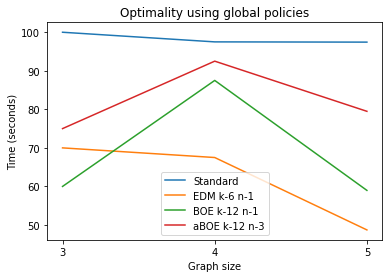

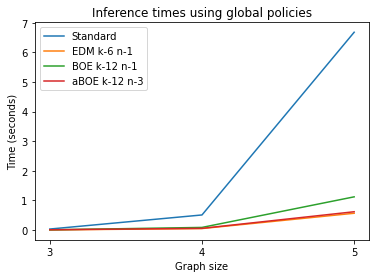

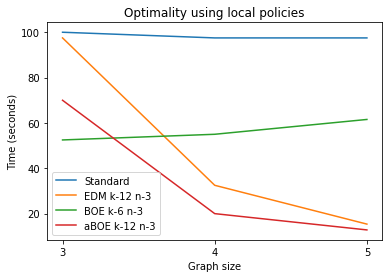

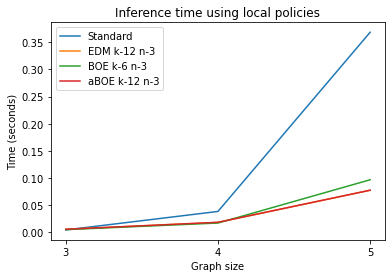

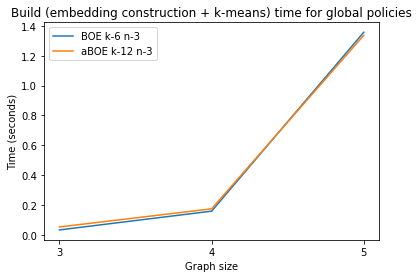

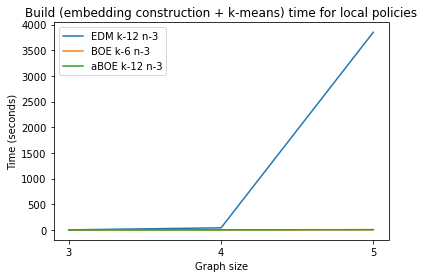

In [258]:
by_graph = data.groupby(['scope', 'embedding', 'k', 'num_cluster_samples', 'graph_size'], dropna=False)

accuracies = by_graph['optimal'].mean()
inference_times = by_graph['inference_times'].mean()
construction_times = by_graph['construction_times'].mean()
kmeans_times = by_graph['kmeans_times'].mean()

build_times = by_graph['build_time'].mean()

global_accuracy = accuracies['global']
local_accuracy = accuracies['local']

global_inf_time = inference_times['global']
local_inf_time = inference_times['local']

global_build_time = build_times['global']
local_build_time = build_times['local']


optimality_dict = {
    'Standard': global_accuracy['None'][''][''],
    'EDM k-6 n-1': global_accuracy['EDM'][6.][1.],
    'BOE k-12 n-1': global_accuracy['BOE'][12.][1.],
    'aBOE k-12 n-3': global_accuracy['aBOE'][12.][3.],
}


inference_time_dict = {
    'Standard': global_inf_time['None'][''][''],
    'EDM k-6 n-1': global_inf_time['EDM'][6.][1.],
    'BOE k-12 n-1': global_inf_time['BOE'][12.][1.],
    'aBOE k-12 n-3': global_inf_time['aBOE'][12.][3.],
}


optimality_local = {
    'Standard': local_accuracy['None'][''][''],
    'EDM k-12 n-3': local_accuracy['EDM'][12.][3.],
    'BOE k-6 n-3': local_accuracy['BOE'][6.][3.],
    'aBOE k-12 n-3': local_accuracy['aBOE'][12.][3.],
}

inference_time_local = {
    'Standard': local_inf_time['None'][''][''],
    'EDM k-12 n-3': local_inf_time['EDM'][12.][3.],
    'BOE k-6 n-3': local_inf_time['BOE'][6.][3.],
    'aBOE k-12 n-3': local_inf_time['aBOE'][12.][3.],
}

build_time_local = {
    'EDM k-12 n-3': local_build_time['EDM'][12.][3.],
    'BOE k-6 n-3': local_build_time['BOE'][6.][3.],
    'aBOE k-12 n-3': local_build_time['aBOE'][12.][3.],
}

build_time_global = {
    'BOE k-6 n-3': global_build_time['BOE'][6.][3.],
    'aBOE k-12 n-3': global_build_time['aBOE'][12.][3.],
}


def plot_stat(datas_dict, size_range, title='', save_name='plot.png'):
    for k, v in datas_dict.items():
        plt.plot(size_range, v, label=k)
    plt.xticks(size_range, size_range)
    plt.title(title)
    plt.xlabel('Graph size')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.savefig(save_name)
    plt.show()

size_range = range(3,6)

plot_stat(optimality_dict, size_range, 'Optimality using global policies', 'optimality_global.png')
plot_stat(inference_time_dict, size_range, 'Inference times using global policies', 'inference_time_global.png')
plot_stat(optimality_local, size_range, 'Optimality using local policies', 'optimality_local.png')
plot_stat(inference_time_local, size_range, 'Inference time using local policies', 'inference_time_local.png')
plot_stat(build_time_global, size_range, 'Build (embedding construction + k-means) time for global policies', 'build_time_global.png')
plot_stat(build_time_local, size_range, 'Build (embedding construction + k-means) time for local policies', 'build_time_local.png')


In [272]:
data[data['k'] == 12.]['inference_times'].mean()

0.1745541390378299

## ADDITIONAL ANALYSES
[NOTE: written to work with older codebase; needs updating]

## EFE of clusters/centers 

[ 16 134 141  13 141 480 153 134 134 412 557  16 412 134 258 258 134 412
  98  16]
center_efes [353.29667472839355, 227.84160709381104, 598.7517423629761, 287.84160709381104, 598.7517423629761, 724.2068099975586, 598.7517423629761, 227.84160709381104, 227.84160709381104, 323.29667472839355, 484.2068099975586, 353.29667472839355, 323.29667472839355, 227.84160709381104, 364.2068099975586, 364.2068099975586, 227.84160709381104, 323.29667472839355, 418.7517423629761, 353.29667472839355]
mean_cluster_efes [307.15600323190495, 241.47822545214396, 400.14872314051576, 246.30623459171605, 400.14872314051576, 521.9522018814087, 383.5476144812573, 241.47822545214396, 241.47822545214396, 298.3716319844693, 420.3271611576349, 307.15600323190495, 298.3716319844693, 241.47822545214396, 310.29064574608435, 310.29064574608435, 241.47822545214396, 298.3716319844693, 348.09362089006527, 307.15600323190495]


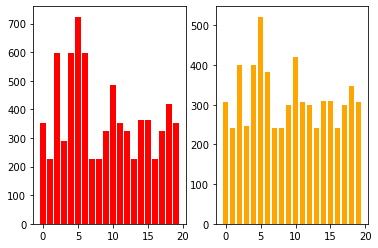

In [655]:
num_samples = 20

cluster_centerss = np.random.choice(local_agent_cluster_centers, size=num_samples)
cc = [19]
print(cluster_centerss)
center_efes = []
mean_cluster_efes = []
for idx, cluster_cent in enumerate(cluster_centers):
    center_efes.append(-evaluate_policy(local_policies[cluster_cent], initial_beliefs[0], A[0], B[0], C[0], weights, weight_coefficient))
    cluster = local_agent_clusters[list(local_agent_cluster_centers).index(cluster_cent)]
    cluster_efes = []
    for c in cluster:
        cluster_efes.append(-evaluate_policy(c, initial_beliefs[0], A[0], B[0], C[0], weights, weight_coefficient)   )
    mean_cluster_efes.append(np.mean(cluster_efes))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar(range(num_samples), center_efes, color='red')
ax2.bar(range(num_samples), mean_cluster_efes, color='orange')

print("center_efes", center_efes)
print("mean_cluster_efes", mean_cluster_efes)

0
center_efes 184.2068099975586
mean_cluster_efes 184.9024157707508


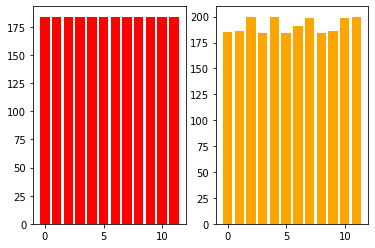

In [735]:
num_clusters = len(local_agent_cluster_centers)

#cluster_cents = np.random.choice(local_agent_cluster_centers, size=num_samples)
#print(cluster_cents)
center_efes = []
mean_cluster_efes = []
for idx, cluster_cent in enumerate(local_agent_cluster_centers):
    center_efes.append(-evaluate_policy(local_policies[cluster_cent], initial_beliefs[0], A[0], B[0], C[0], weights, weight_coefficient))
    cluster = local_agent_clusters[list(local_agent_cluster_centers).index(cluster_cent)]
    cluster_efes = []
    for c in cluster:
        cluster_efes.append(-evaluate_policy(c, initial_beliefs[0], A[0], B[0], C[0], weights, weight_coefficient)   )
    mean_cluster_efes.append(np.mean(cluster_efes))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar(range(num_clusters), center_efes, color='red')
ax2.bar(range(num_clusters), mean_cluster_efes, color='orange')

i = np.argmin(center_efes)
print(i)
print("center_efes", center_efes[i])
print("mean_cluster_efes", mean_cluster_efes[i])


## 2D PCA / K-means visualization

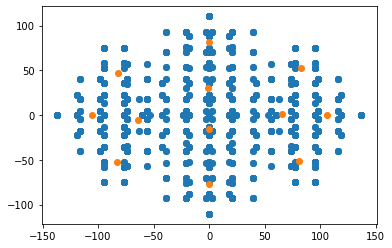

In [48]:
pca = PCA(n_components=2)
pca.fit(emb)

reduced_matrix = pca.transform(matrix)
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])
plt.show()

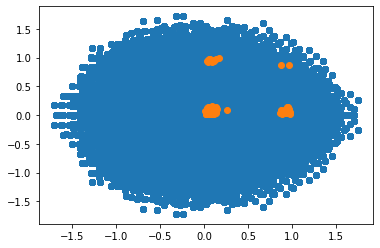

In [103]:
kmeans_bop2 = KMeans(n_clusters=100, random_state=0).fit(np.array(bop))
kmeans_bop2.cluster_centers_

kmeans_bop2.cluster_centers_[0]
pca = PCA(n_components=2)
pca.fit(bop)

reduced_matrix = pca.transform(bop)
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(kmeans_bop2.cluster_centers_[:,0], kmeans_bop2.cluster_centers_[:,1])
plt.show()

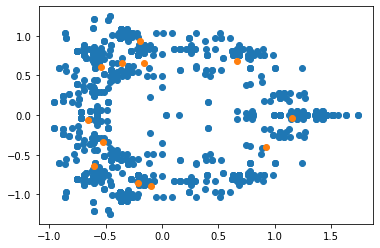

In [736]:
emb = embeddings_dict[(0,0)]["embedding"]
km = embeddings_dict[(0,0)]["kmeans"]

pca = PCA(n_components=2)
pca.fit(emb)

reduced_matrix = pca.transform(emb)
reduced_clusbop = pca.transform(km.cluster_centers_)

plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(reduced_clusbop[:,0], reduced_clusbop[:,1])

plt.show()

In [685]:
embeddings_dict

{(0,
  2): {'embedding': [array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 8]),
   array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 8]),
   array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 8]),
  

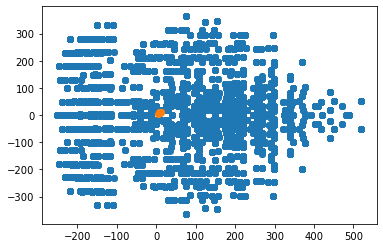

In [180]:
pca = PCA(n_components=3)
pca.fit(matrix)
reduced_matrix = pca.transform(matrix)

plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(kmeans_unreduced.cluster_centers_[:,0], kmeans_unreduced.cluster_centers_[:,1])

plt.show()

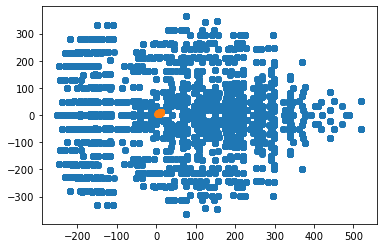

In [192]:
pca = PCA(n_components=3)
pca.fit(matrix)
reduced_matrix = pca.transform(matrix)

plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1])
plt.scatter(kmeans_matrix.cluster_centers_[:,0], kmeans_matrix.cluster_centers_[:,1])
#plt.scatter(kmeans_bop.cluster_centers_[65,0], kmeans_bop.cluster_centers_[65,1])


plt.show()